In [51]:
import glob
import pandas as pd
import matplotlib.pyplot as plt 
import json 
import random
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [52]:
#Read the txt into a list and then into a dataframe
def read_txt(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return lines

path = 'data/reviews_url.txt'

urls = read_txt(path)

urls_df = pd.DataFrame(urls, columns=['url'])

print (urls_df.head(10))

                                                 url
0  http://www.imdb.com/title/tt0064354/usercommen...
1  http://www.imdb.com/title/tt0100680/usercommen...
2  http://www.imdb.com/title/tt0100680/usercommen...
3  http://www.imdb.com/title/tt0100680/usercommen...
4  http://www.imdb.com/title/tt0047200/usercommen...
5  http://www.imdb.com/title/tt0893406/usercommen...
6  http://www.imdb.com/title/tt0893406/usercommen...
7  http://www.imdb.com/title/tt0893406/usercommen...
8  http://www.imdb.com/title/tt0893406/usercommen...
9  http://www.imdb.com/title/tt0893406/usercommen...


In [53]:
#Read all files from a folder and save them in a dataframe
path = 'data/reviews/'
all_files = glob.glob(path + "/*.txt")

reviews = []

for filename in all_files:
    with open(filename, 'r') as f:
        data = f.read()
        reviews.append(data)

#Clean non alphanumeric characters in each review from the reviews list
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

reviews = [clean_text(review) for review in reviews]

#Create a dataframe with the reviews
reviews_df = pd.DataFrame(reviews, columns=['review'])

print(reviews_df.head(10))

                                              review
0  working with one of the best shakespeare sourc...
1  welltremors i the original started off in 1990...
2  ouch this one was a bit painful to sit through...
3  ive seen some crappy movies in my life but thi...
4  carriers follows the exploits of two guys and ...
5  i had been looking forward to seeing this film...
6  effects without cause is generally not possibl...
7  this picture started out with good intentions ...
8  i chose to see this movie because it got a goo...
9  this film has to be the worst i have ever seen...


In [54]:
#Join the dataframe with the urls and the reviews
data = pd.concat([urls_df, reviews_df], axis=1)

print(data.head(10))

                                                 url  \
0  http://www.imdb.com/title/tt0064354/usercommen...   
1  http://www.imdb.com/title/tt0100680/usercommen...   
2  http://www.imdb.com/title/tt0100680/usercommen...   
3  http://www.imdb.com/title/tt0100680/usercommen...   
4  http://www.imdb.com/title/tt0047200/usercommen...   
5  http://www.imdb.com/title/tt0893406/usercommen...   
6  http://www.imdb.com/title/tt0893406/usercommen...   
7  http://www.imdb.com/title/tt0893406/usercommen...   
8  http://www.imdb.com/title/tt0893406/usercommen...   
9  http://www.imdb.com/title/tt0893406/usercommen...   

                                              review  
0  working with one of the best shakespeare sourc...  
1  welltremors i the original started off in 1990...  
2  ouch this one was a bit painful to sit through...  
3  ive seen some crappy movies in my life but thi...  
4  carriers follows the exploits of two guys and ...  
5  i had been looking forward to seeing this film... 

In [55]:
#iloc is used to select rows and columns by number, in the order that they appear in the data frame
x = data.iloc[0]
x

url       http://www.imdb.com/title/tt0064354/usercommen...
review    working with one of the best shakespeare sourc...
Name: 0, dtype: object

In [56]:
x['review']

'working with one of the best shakespeare sources this film manages to be creditable to its source whilst still appealing to a wider audiencebr br branagh steals the film from under fishburnes nose and theres a talented cast on good form'

In [57]:
#This would be necessary in case the contents of a column contained more than a single string
#So we could join the strings into a single one

#j = json.loads(x['review'])
#j
#' '.join(''.join(jj['name'].split()) for jj in j)

In [58]:
#This too would be necessary in case the contents of a column contained more than a single string

# convert the relevant data for each movie into a single string
# to be ingested by TfidfVectorizer
def urls_and_reviews_to_string(row):
  urls = json.loads(row['url'])
  urls = ' '.join(''.join(j['name'].split()) for j in urls)

  reviews = json.loads(row['review'])
  reviews = ' '.join(''.join(j['name'].split()) for j in reviews)
  return "%s %s" % (urls, reviews)

In [59]:
#create a tf-idf vectorizer object
#max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

In [60]:
#Create a data matrix from the reviews
X = tfidf.fit_transform(data['review'])

In [61]:
X

<12500x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 711597 stored elements in Compressed Sparse Row format>

In [73]:
query = X[2345]
query

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [74]:
#Print the query vector
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [75]:
#compute similarity between query and every vector in X
scores = cosine_similarity(query, X)
scores

array([[0.02142096, 0.02671692, 0.0866394 , ..., 0.        , 0.03615948,
        0.0075772 ]])

In [76]:
# currently the array is 1 x N, make it just a 1-D array
scores = scores.flatten()

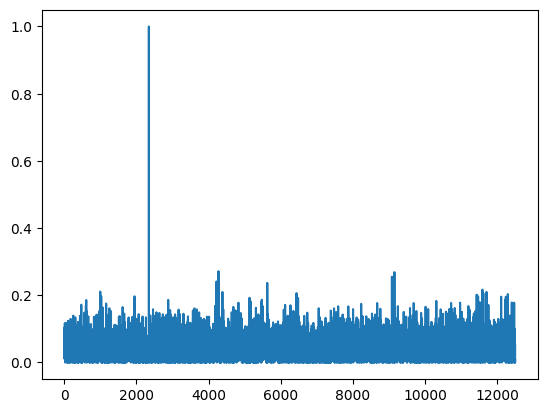

In [77]:
plt.plot(scores)

In [78]:
(-scores).argsort()

array([2345, 4275, 9152, ..., 3592, 3673, 5135])

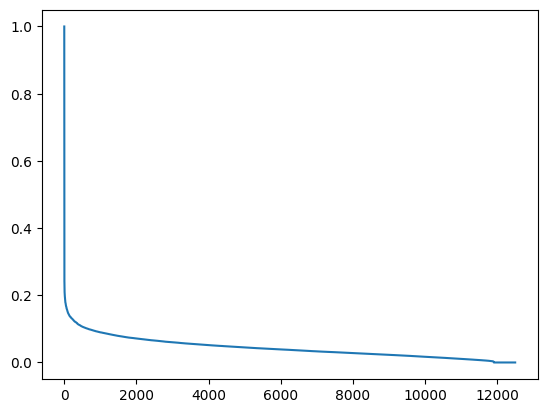

In [79]:
plt.plot(scores[(-scores).argsort()])

In [80]:
#Get the top 10 most similar reviews
top_10 = (-scores).argsort()[:10]
# The - sign is used to sort in descending order

In [81]:
#convert indices to urls
data.iloc[top_10]['url']

2345     http://www.imdb.com/title/tt0049966/usercommen...
4275     http://www.imdb.com/title/tt0098936/usercommen...
9152     http://www.imdb.com/title/tt0364986/usercommen...
9082     http://www.imdb.com/title/tt0240900/usercommen...
4220     http://www.imdb.com/title/tt0111285/usercommen...
5627     http://www.imdb.com/title/tt0217749/usercommen...
11591    http://www.imdb.com/title/tt0097981/usercommen...
998      http://www.imdb.com/title/tt0463027/usercommen...
11705    http://www.imdb.com/title/tt0040109/usercommen...
4384     http://www.imdb.com/title/tt0380687/usercommen...
Name: url, dtype: object

In [82]:
#convert indices to reviews
data.iloc[top_10]['review']

2345     another movie to suffer without an adventure t...
4275     i love all his work but this looks like nothin...
9152     spoiles lame south of the border adventure mov...
9082     rob schneider is a famous comedian cause of hi...
4220     trying to compare or represent this swill as a...
5627     the movie is bad nothing special  just a kid m...
11591    theres a lot of movies that have set release d...
998      given the people involved it is hard to see wh...
11705    i anticipated the release of the film as much ...
4384     everything a great documentary could be yeah i...
Name: review, dtype: object

In [83]:
#Save indices, urls and reviews to a csv file 
with open("top_10.csv", 'w') as f:
    data.iloc[top_10].to_csv(f)

In [84]:
#Create a function to do the same as above
def recommend(index):
    #Get the vector in the dataframe for an index
    query = X[index]
    #Compute pairwise similarity between the query vector and all the vectors in the dataframe
    scores = cosine_similarity(query, X)
    #Currently the array is 1 x N, make it just a 1-D array
    scores = scores.flatten()
    #Plot the scores
    plt.plot(scores)
    #Plot the scores in descending order
    plt.plot(scores[(-scores).argsort()])
    #Get the top 6 most similar reviews
    top_6 = (-scores).argsort()[1:7]
    #Convert indices to urls
    print(data.iloc[top_6]['url'])
    #Convert indices to reviews
    print(data.iloc[top_6]['review'])
    #Save indices, urls and reviews to a csv file
    with open("top_6_{}.csv".format(index), 'w') as f:
        data.iloc[top_6].to_csv(f)

In [ ]:
print("Recommendations for index 4435:\n")
